# Training Set Debugging with AutoDC
To demonstrate training set debugging with AutoDC, we will use a pipeline using images from the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) data, as well as relational data, and data from a log-file. The pipeline is implemented using native constructs from the popular `pandas`, `scikit-learn`, and `keras` libraries.
First, let us take a look at the overview from the abstract again.

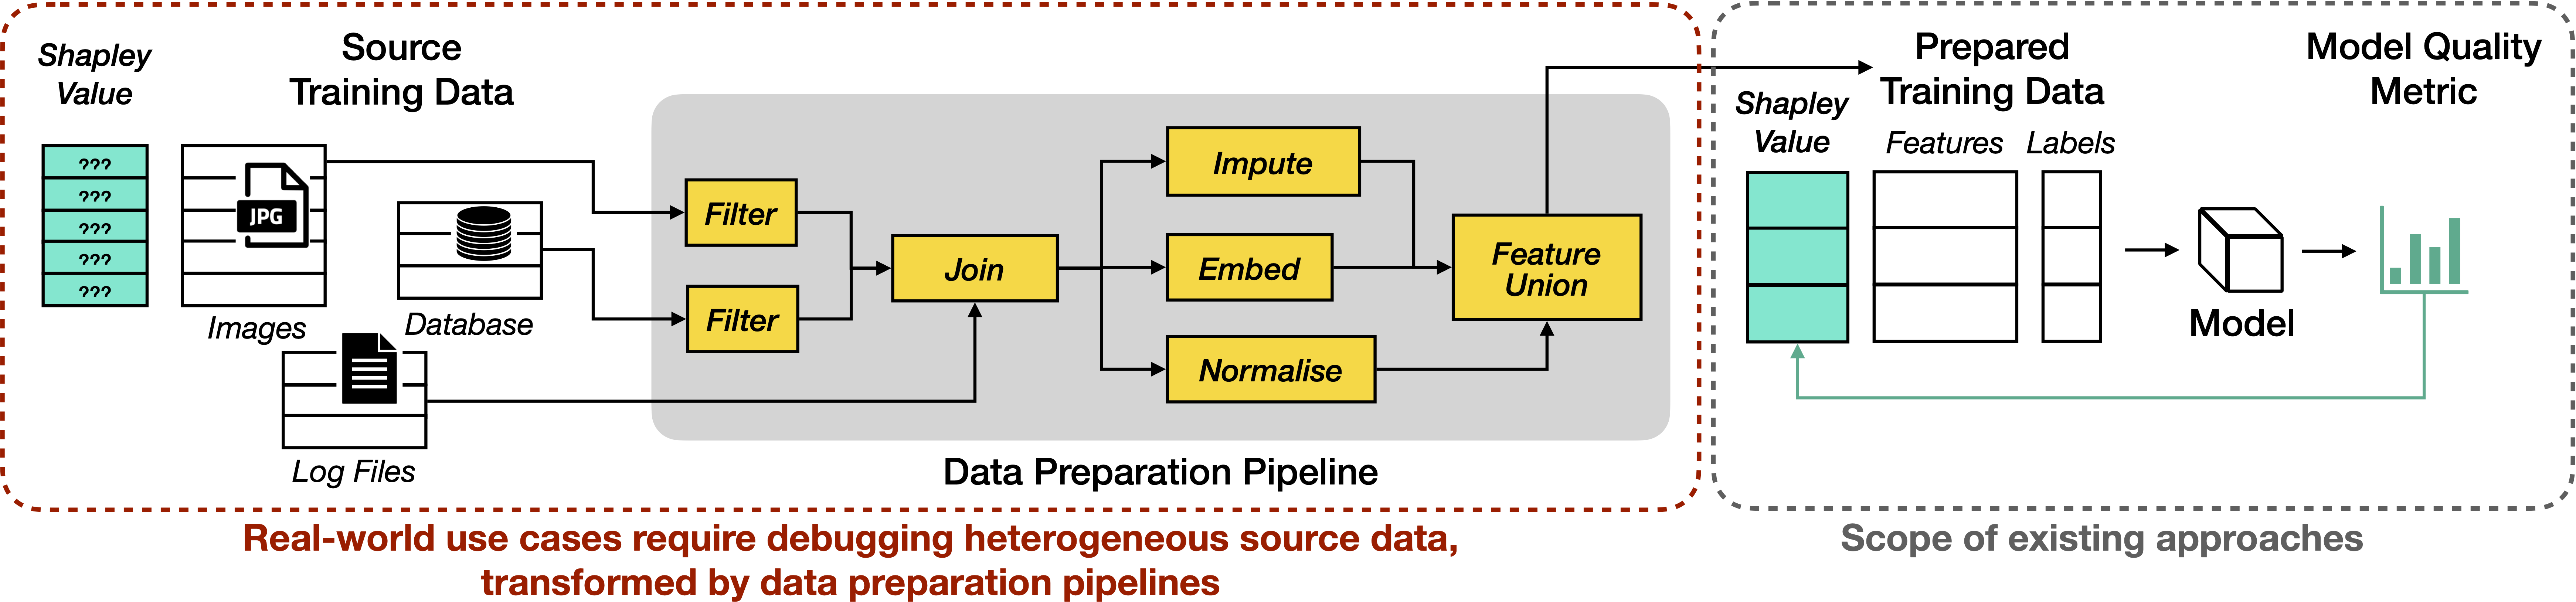

In [1]:
from demo.feature_overview.demo_utils import display_abstract_figure, display_demo_source_code
display_abstract_figure()

The pipeline in the Figure is loosely based on the source code from our example pipeline.
Let us now look at the full pipeline [source code](https://anonymous.4open.science/r/autodc/demo/dc_demo/sneakers.py).

In [2]:
import os
from mlwhatif.utils import get_project_root

DEMO_PY = os.path.join(str(get_project_root()), "demo", "dc_demo", "sneakers.py")
display_demo_source_code(DEMO_PY)

In this scenario, we realized that there are likely some mislabeled photos in the image inputs to our pipeline. Thus, we want to try several training set debugging techniques to see how much they help in our scenario.

To conduct our tests, we do not need to rewrite this pipeline file, we can use it directly as input for AutoDC. AutoDC can then automatically rewrite the pipeline to try the data-centric techniques of interest.

AutoDC already provides pipeline-independent code for training set debugging. It is the analysis `TrainingSetDebugging`. We want to try four different cleaning approaches for the mislabed rows, based on two existing papers.

The central entry point of AutoDC is the `PipelineAnalyzer`. To use AutoDC, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a sneakers.py file, but e.g., `.ipynb` jupyter notebook files are supported, too. Then, we define the set of data-centric techniques we want AutoDC to run. Then, we execute the pipeline. AutoDC returns a `AnalysisResults` object, which contains the output of our analysis.

In [13]:
from mlwhatif import PipelineAnalyzer
from demo.dc_demo.demo_utils import TrainingSetDebugging
import warnings
warnings.filterwarnings('ignore')  # To keep the output readable


training_set_debugging = TrainingSetDebugging()

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(training_set_debugging) \
    .execute()

debugging_report = analysis_result.analysis_to_result_reports[training_set_debugging]

2023-05-24 23:57:20 INFO  Running instrumented original pipeline...
2023-05-24 23:57:20 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2023-05-24 23:57:20 INFO  ---RUNTIME: Importing and monkey-patching took 9.507894515991211 ms
2023-05-24 23:57:29 INFO  ---RUNTIME: Original pipeline execution took 8398.37098121643 ms (excluding imports and monkey-patching)
2023-05-24 23:57:29 INFO  Starting execution of 1 what-if analyses...
2023-05-24 23:57:29 INFO  Start plan generation for analysis TrainingSetDebugging...
2023-05-24 23:57:29 INFO  ---RUNTIME: Plan generation took 1.589059829711914 ms
2023-05-24 23:57:29 INFO  Estimated runtime of original DAG is 8349.456310272217ms
2023-05-24 23:57:29 INFO  Performing Multi-Query Optimization
2023-05-24 23:57:29 INFO  Estimated unoptimized what-if runtime is 33397.82524108887ms
2023-05-24 23:57:29 INFO  Estimated optimised what-if runtime is 29102.241039276123ms
2023-05-24 23:57:29 INFO  Es

Let us now look at the report generated by the `TrainingSetDebugging` analysis. Each row in this pandas `DataFrame` corresponds to one pipeline variant executed by AutoDC. In the first report column, we see a column from the original pipeline that was cleaned in this pipeline variant; in this demo, we only look at label errors. In the second column, we see the type of data error that was analysed; in this demo, we only consider mislabeled rows. In the third column, we see which technique was used to detect potentially mislabeled rows and how mislabeled rows were handled in the variant. In the fourth column, we see the utility score of the variant.

In the first row, we see the output for the original pipeline.

Here, we find that detecting mislabeled rows using kNN-Shapley and then automatically flipping the binary label results in the highest performance increase for our pipeline.

In [14]:
debugging_report

corrupted_column     error  cleaning_method  accuracy_score_L83
0             None      None             None            0.964602
1             None  mislabel  cleanlab_delete            0.960177
2             None  mislabel  cleanlab_update            0.946903
3             None  mislabel   shapley_delete            0.951327
4             None  mislabel   shapley_update            0.982301

## How it works internally

Internally, AutoDC extracts a dataflow plan from the user's pipeline source code. Based on a declarative definition of the analysis to perform from the user, AutoDC then automatically rewrites the pipeline to apply the data-centric techniques of interest. For this, it uses so-called `pipeline patches`. Finally, it executes the pipeline variants of interest using multi-query optimisation.

In [4]:
from demo.feature_overview.demo_utils import display_anon_overview_figure
display_anon_overview_figure()
